### Created by: Anthony D. Cho
### Last update: 27.11.2021

**Subject**: Classification (CNN, data augmentation - keras, tensorflow) - Flowers Recognition

In [1]:
## Librerias generales
import os
import matplotlib.pyplot as plt
%matplotlib inline

from time import time
from glob import glob
from numpy import zeros, array, argmax, vstack

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

## Keras tensorflow
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.optimizers import Adam

### Customized function

In [2]:
def plot_history(history, width=12, height=6):
  """
  DESCRIPTION:
    History performance of the keras model
  
  INPUT:
    @param history: history of performance of fitted model
    @type history: tensorflow.python.keras.callbacks.History

  OUTPUT:
    A graphic
  """

  ## Metrics keys stored in tensorflow object
  keys = list(history.history.keys())

  ## Number of epoch used for fit the model
  epoch = range(1, len(history.epoch) +1)

  ## Check if validation set was used.
  withValidation = False
  for key in keys:
    if 'val' in key:
      withValidation = True

  ## Number of metrics 
  nMetrics = len(keys)
  if withValidation:
    nMetrics = nMetrics//2

  ## Plot-space instance
  plt.figure(figsize=(width, height))

  for i in range(nMetrics):
    plt.subplot(nMetrics, 1, i+1)

    ## Plot (train) metric value
    labelMetric = keys[i]
    metric = history.history[keys[i]]
    plt.plot(epoch, metric, 'o-', label=labelMetric)

    if withValidation:
      ## Plot (validation) metric value
      labelMetricVal = keys[i+nMetrics]
      metricVal = history.history[keys[i+nMetrics]]
      plt.plot(epoch, metricVal, 'o-', label=labelMetricVal)

    plt.xlim(epoch[0], epoch[-1])
    plt.legend()
    plt.grid()

  plt.xlabel('Epoch')
  plt.show()

**Data source:**

[Flowers classification](https://www.kaggle.com/alxmamaev/flowers-recognition) (Classification)

In [3]:
if not os.path.exists("dataFlowers.zip"):
    ## Download files

    !wget https://github.com/adoc-box/Datasets/raw/main/flowers.zip
    !wget https://github.com/adoc-box/Datasets/raw/main/flowers.z01

    ## join files 
    !zip -F flowers.zip --out dataFlowers.zip

    ## remove some files
    !rm flowers.z01 flowers.zip

    ## un-compress joined zip file
    !unzip dataFlowers.zip
    
else:
    if os.path.exists('data'):
        !rm -r data
        !unzip dataFlowers.zip

Se truncaron las últimas líneas 5000 del resultado de transmisión.
 copying: data/train/rose/3576488381_611f3446e0_n.jpg
 copying: data/train/rose/3624546109_8eb98f0cdb.jpg
 copying: data/train/rose/3634244527_e72c47842c_n.jpg
 copying: data/train/rose/3654988152_b11178bbcb.jpg
 copying: data/train/rose/3655527028_0fab2b547d_n.jpg
 copying: data/train/rose/3661675690_ed2d05fa5f_n.jpg
 copying: data/train/rose/3664842094_5fd60ee26b.jpg
 copying: data/train/rose/3667366832_7a8017c528_n.jpg
 copying: data/train/rose/3873271620_1d9d314f01_n.jpg
 copying: data/train/rose/3909587261_f8cd3e7fe7.jpg
 copying: data/train/rose/394990940_7af082cf8d_n.jpg
 copying: data/train/rose/4061451210_1650590c6a.jpg
 copying: data/train/rose/4093390305_4010c736c9.jpg
 copying: data/train/rose/410421672_563550467c.jpg
 copying: data/train/rose/410425647_4586667858.jpg
 copying: data/train/rose/4242976586_607a8f9843_n.jpg
 copying: data/train/rose/4279989256_9a48c0d194_n.jpg
 copying: data/train/rose/42799908

### Image loader generator

In [4]:
## Images PATHs
train_dir = 'data/train/'
validation_dir = 'data/validation/'
test_dir = 'data/test/'

## Image generator instances
train_datagen = ImageDataGenerator(rescale=1./255, 
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

## Image conversion size
imgSize = 150

## Generator setting (Train)
train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to (imgSize x imgSize)
        target_size=(imgSize, imgSize), ## 224
        batch_size=20,
        # Since we use categorical_crossentropy loss, we need categorical labels
        class_mode='categorical')

## Generator setting (Validation)
validation_generator = val_datagen.flow_from_directory(
        validation_dir,
        target_size=(imgSize, imgSize),
        batch_size=20,
        shuffle=False,
        class_mode='categorical')

## Generator setting (test)
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(imgSize, imgSize),
        batch_size=20,
        shuffle=False,
        class_mode='categorical')

Found 2313 images belonging to 5 classes.
Found 554 images belonging to 5 classes.
Found 380 images belonging to 5 classes.


### Model building

In [5]:
## Model design
def get_model():
    """
        CNN Model builder
    """

    ## Model instance

    model = Sequential(name='FlowersRecognition')
    model.add(layers.Conv2D(filters=32, 
                            kernel_size=(3, 3), 
                            activation='relu',
                            input_shape=(150, 150, 3),
                            name='Conv2D_01'))
    model.add(layers.MaxPooling2D(pool_size=(2, 2),
                                  name='Pooling_01'))
    model.add(layers.Conv2D(filters=64, 
                            kernel_size=(3, 3), 
                            activation='relu',
                            name='Conv2D_02'))
    model.add(layers.MaxPooling2D(pool_size=(2, 2),
                                  name='Pooling_02'))
    model.add(layers.Conv2D(filters=128, 
                            kernel_size=(3, 3), 
                            activation='relu',
                            name='Conv2D_03'))
    model.add(layers.MaxPooling2D(pool_size=(2, 2),
                                  name='Pooling_03'))
    model.add(layers.Conv2D(filters=128, 
                            kernel_size=(3, 3), 
                            activation='relu',
                            name='Conv2D_04'))
    model.add(layers.MaxPooling2D(pool_size=(2, 2),
                                  name='Pooling_04'))
    model.add(layers.Flatten(name='Flatten'))
    model.add(layers.Dense(units=512, 
                          activation='relu',
                          name='Dense_01'))
    model.add(layers.Dense(units=5, 
                          activation='softmax',
                          name='output'))
    
    ## return model 
    return model

In [ ]:
## model instance
model = get_model()

model.summary()

Model: "FlowersRecognition"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Conv2D_01 (Conv2D)          (None, 148, 148, 32)      896       
                                                                 
 Pooling_01 (MaxPooling2D)   (None, 74, 74, 32)        0         
                                                                 
 Conv2D_02 (Conv2D)          (None, 72, 72, 64)        18496     
                                                                 
 Pooling_02 (MaxPooling2D)   (None, 36, 36, 64)        0         
                                                                 
 Conv2D_03 (Conv2D)          (None, 34, 34, 128)       73856     
                                                                 
 Pooling_03 (MaxPooling2D)   (None, 17, 17, 128)       0         
                                                                 
 Conv2D_04 (Conv2D)          (None, 15, 15, 128)

In [ ]:
start = time()

## Compiler setting
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=1e-4),
              metrics=['acc'])

## Model fitting
history = model.fit(
      train_generator, 
      steps_per_epoch=115,  ## <- 2312 images / batch size of 20 approx 115
      validation_data=validation_generator,
      validation_steps=27,  ## <- 554 images / batch size of 20 approx 27
      epochs=80, verbose=1)

timeUp = time()-start
print('\nTime spent[s]: {:.2f}'.format(timeUp))

model.save('ConvNet_DataAugmented.h5')

Epoch 1/80
115/115 [==============================] - 22s 187ms/step - loss: 1.4289 - acc: 0.3598 - val_loss: 1.2562 - val_acc: 0.4648
Epoch 2/80
115/115 [==============================] - 23s 203ms/step - loss: 1.2067 - acc: 0.4771 - val_loss: 1.1575 - val_acc: 0.4907
Epoch 3/80
115/115 [==============================] - 23s 200ms/step - loss: 1.1356 - acc: 0.5290 - val_loss: 1.1993 - val_acc: 0.4870
Epoch 4/80
115/115 [==============================] - 22s 187ms/step - loss: 1.0941 - acc: 0.5587 - val_loss: 1.0589 - val_acc: 0.5741
Epoch 5/80
115/115 [==============================] - 22s 194ms/step - loss: 1.0315 - acc: 0.5857 - val_loss: 1.1032 - val_acc: 0.5852
Epoch 6/80
115/115 [==============================] - 22s 193ms/step - loss: 0.9784 - acc: 0.6201 - val_loss: 0.9576 - val_acc: 0.6278
Epoch 7/80
115/115 [==============================] - 23s 201ms/step - loss: 0.9734 - acc: 0.6149 - val_loss: 0.9441 - val_acc: 0.6556
Epoch 8/80
115/115 [==============================] - 2

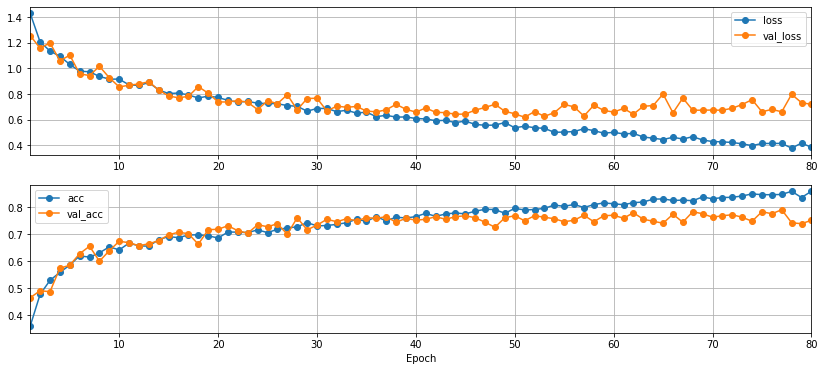

19/19 [==============================] - 1s 67ms/step - loss: 0.7999 - acc: 0.7368
[0.7999087572097778, 0.7368420958518982]


In [ ]:
## display performances
plot_history(history, width=14)

## restart test generator index
test_generator.reset()

## evaluate test set in the model
print(model.evaluate(test_generator, 
                     steps=19))  ## <- 380 images / batch size of 20 equal 19

## restart test generator index
test_generator.reset()

## Compute prediction using test generator
prediction = model.predict(test_generator, steps=19)

In [ ]:
## restart test generator index
test_generator.reset()

## labels allocation
i, y_true = 0, []
for _, y in test_generator:
    y_true.append(y)
    i+=1
    if i == 19:
      break
y_true = vstack(y_true)

## Decoding labels
y_true = argmax(y_true, axis=1)
prediction_decoded = argmax(prediction, axis=1)

In [ ]:
y_true.shape, prediction_decoded.shape

((380,), (380,))

In [ ]:
## display confusion matrix
print(confusion_matrix(y_true=y_true, y_pred=prediction_decoded))

## display classification report
print(classification_report(y_true=y_true, y_pred=prediction_decoded))

[[47  3 10  7  3]
 [ 5 54  7 18  6]
 [ 2  1 50  5 12]
 [ 0  0  4 64  3]
 [ 3  0  9  2 65]]
              precision    recall  f1-score   support

           0       0.82      0.67      0.74        70
           1       0.93      0.60      0.73        90
           2       0.62      0.71      0.67        70
           3       0.67      0.90      0.77        71
           4       0.73      0.82      0.77        79

    accuracy                           0.74       380
   macro avg       0.76      0.74      0.74       380
weighted avg       0.76      0.74      0.74       380



## Best model

Looking into the performance charts, it seems to stabilize (kind of overfit) starting at epoch 45.

In [6]:
## Restart all generators
train_generator.reset()
validation_generator.reset()
test_generator.reset()

In [7]:
## Model instance
model = get_model()

model.summary()

Model: "FlowersRecognition"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Conv2D_01 (Conv2D)          (None, 148, 148, 32)      896       
                                                                 
 Pooling_01 (MaxPooling2D)   (None, 74, 74, 32)        0         
                                                                 
 Conv2D_02 (Conv2D)          (None, 72, 72, 64)        18496     
                                                                 
 Pooling_02 (MaxPooling2D)   (None, 36, 36, 64)        0         
                                                                 
 Conv2D_03 (Conv2D)          (None, 34, 34, 128)       73856     
                                                                 
 Pooling_03 (MaxPooling2D)   (None, 17, 17, 128)       0         
                                                                 
 Conv2D_04 (Conv2D)          (None, 15, 15, 128)

In [8]:
start = time()

## Compiler setting
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=1e-4),
              metrics=['acc'])

## Model fitting
history = model.fit(
      train_generator, 
      steps_per_epoch=115,  ## <- 2312 images / batch size of 20 approx 115
      epochs=45, verbose=1)

timeUp = time()-start
print('\nTime spent[s]: {:.2f}'.format(timeUp))

model.save('ConvNet_simple.h5')

Epoch 1/45
115/115 [==============================] - 30s 174ms/step - loss: 1.4655 - acc: 0.3249
Epoch 2/45
115/115 [==============================] - 20s 171ms/step - loss: 1.2338 - acc: 0.4636
Epoch 3/45
115/115 [==============================] - 20s 173ms/step - loss: 1.1512 - acc: 0.5124
Epoch 4/45
115/115 [==============================] - 20s 173ms/step - loss: 1.0870 - acc: 0.5578
Epoch 5/45
115/115 [==============================] - 20s 174ms/step - loss: 1.0594 - acc: 0.5774
Epoch 6/45
115/115 [==============================] - 20s 174ms/step - loss: 1.0333 - acc: 0.5953
Epoch 7/45
115/115 [==============================] - 20s 173ms/step - loss: 0.9698 - acc: 0.6276
Epoch 8/45
115/115 [==============================] - 20s 173ms/step - loss: 0.9812 - acc: 0.6062
Epoch 9/45
115/115 [==============================] - 20s 175ms/step - loss: 0.9613 - acc: 0.6280
Epoch 10/45
115/115 [==============================] - 20s 175ms/step - loss: 0.9166 - acc: 0.6507
Epoch 11/45
115/115

In [9]:
## restart test generator index
test_generator.reset()

## evaluate test set in the model
print(model.evaluate(test_generator, 
                     steps=19))  ## <- 380 images / batch size of 20 equal 19

## restart test generator index
test_generator.reset()

## Compute prediction using test generator
prediction = model.predict(test_generator, steps=19)

19/19 [==============================] - 2s 66ms/step - loss: 0.7116 - acc: 0.7316
[0.7116460800170898, 0.7315789461135864]


In [10]:
## restart test generator index
test_generator.reset()

## labels allocation
i, y_true = 0, []
for _, y in test_generator:
    y_true.append(y)
    i+=1
    if i == 19:
      break
y_true = vstack(y_true)

## Decoding labels
y_true = argmax(y_true, axis=1)
prediction_decoded = argmax(prediction, axis=1)

In [11]:
## display confusion matrix
print(confusion_matrix(y_true=y_true, y_pred=prediction_decoded))

## display classification report
print(classification_report(y_true=y_true, y_pred=prediction_decoded))

[[49  5  9  1  6]
 [ 1 70  2  7 10]
 [ 3  3 49  2 13]
 [ 0  5  4 55  7]
 [ 1  6 16  1 55]]
              precision    recall  f1-score   support

           0       0.91      0.70      0.79        70
           1       0.79      0.78      0.78        90
           2       0.61      0.70      0.65        70
           3       0.83      0.77      0.80        71
           4       0.60      0.70      0.65        79

    accuracy                           0.73       380
   macro avg       0.75      0.73      0.74       380
weighted avg       0.75      0.73      0.74       380

